In [1]:

import os
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

INPUT_LENGTH = 3600

# If possible we should use the GPU to train/test the mode, this tremendously speeds up calculations.
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using %s' % (device))

TRAIN_PATH_CLEAN = 'spectra_train_clean.csv'
# NOTE: in this file we use test and validation sets, but we accidentally swapped their names around
# We use the test set for hyperparameter tuning and threshold tuning, and the validation set for a final evaluation
# whereas you would usually do the opposite. 
TEST_PATH = 'spectra_test.csv'
VALIDATION_PATH = 'spectra_validation.csv'

# Index -> functional group name
label_map = [
    'phenol',
    'aldehyde',
    'arene'
]
num_classes = len(label_map)

class IRDataset(Dataset):
    def __init__(self, csv_path, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_path)
        # Parse all the json encoded spectra
        self.df['spectrum'] = self.df['spectrum'].apply(json.loads)
        self.df['labels'] = self.df['labels'].apply(json.loads)
        # The labels are already given as multi-hot vector arrays, but torch expects them as tensors.
        self.df['labels'] = self.df['labels'].apply(lambda L: torch.tensor(L, dtype=torch.float32))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)        

    def __getitem__(self, idx):
        spectrum = self.df['spectrum'].iloc[idx]
        # Torch expects spectra as a tensor, not a list
        spectrum = torch.tensor(spectrum, dtype=torch.float32)
        
        labels = self.df['labels'].iloc[idx]
        
        if (self.transform):
            spectrum = self.transform(spectrum)
        if (self.target_transform):
            labels = self.target_transform(labels)
        return spectrum, labels 

# Since the dataset is imbalanced we might see performance improvements from altering the pos_weights
# pos_weights determine how heavily a false negative is punished, higher pos_weight -> higher loss for a false negative
def get_pos_weights(dataset):
    weights = []
    total = len(dataset.df)
    for i in range(len(label_map)):
        number_of_label = dataset.df['labels'].apply(lambda L: bool(L[i] == 1)).sum()
        # The usual formula for pos_weights is 
        # (total_samples - positive_samples) / positive_samples
        weights.append((total - number_of_label) / number_of_label)
    weights = torch.tensor(weights, dtype=torch.float32)
    return weights
    
test_set = IRDataset(TEST_PATH)
test_loader = DataLoader(test_set, batch_size=64)

C:\Users\20234238\AppData\Local\anaconda3\envs\cbl_ir\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
Using cuda


In [2]:
# Precision is the proportion of correct positive predictions
def precision(predictions, true_labels, label_index):
    true_positive = sum((predictions[i][label_index] == 1).item() and (true_labels[i][label_index] == 1).item() for i in range(len(predictions)))
    false_positive = sum((predictions[i][label_index] == 1).item() and (true_labels[i][label_index] == 0).item() for i in range(len(predictions)))
    if true_positive == 0:
        return 0.0
    return true_positive / (true_positive + false_positive)

# Recall is the proportion of positives correctly predicted as positives
def recall(predictions, true_labels, label_index):
    true_positive = sum((predictions[i][label_index] == 1).item() and (true_labels[i][label_index] == 1).item() for i in range(len(predictions)))
    false_negative = sum((predictions[i][label_index] == 0).item() and (true_labels[i][label_index] == 1).item() for i in range(len(predictions)))
    if true_positive == 0:
        return 0.0
    return true_positive / (true_positive + false_negative)

# F1-score is a balanced mean between precision and recall
def f1_score(predictions, true_labels, label_index):
    precision_score = precision(predictions, true_labels, label_index)
    recall_score = recall(predictions, true_labels, label_index)
    if precision_score == 0 and recall_score == 0:
        return 0.0
    return 2 * precision_score * recall_score / (precision_score + recall_score)

# Exact match ratio is the percentage of predictions that exactly matched the true labels
def EMR(predictions, true_labels):
    return (predictions == true_labels).all(axis=1).mean()


def batch_to_conv_input(batch_input):
    # The CNN expects batch_inputs to have a channel dimension (like [batch_size, 1, input_length]), but currently
    # batch_input has no channel and the dimensions of batch_inputs are [64, 3600].
    # unsqueeze adds a channel dimension in the middle, so batch_input's dimensions become [64, 1, 3600]
    return batch_input.unsqueeze(1)

# Trains the model for one epoch
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device='cpu'):
    model.train()
    
    for batch_inputs, batch_labels in dataloader:
            batch_inputs = batch_to_conv_input(batch_inputs).to(device)
            batch_labels = batch_labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            # NOTE: do not forget to call scheduler.step after evaluating the epoch!

# Evaluates the model, returning various metrics like F1/EMR/precision/recall for every class
def evaluate(model, data_loader, device='cpu', thresholds = [0.5, 0.5, 0.5]):
    # Set model to evaluation mode (disabled dropout, weight regularization, etc)
    model.eval() 
    
    all_true_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_to_conv_input(batch_inputs).to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_inputs)
            # Convert from raw logits to probabilities
            probabilities = torch.sigmoid(outputs)
            
            thresholds_tensor = torch.tensor(thresholds, device=device).unsqueeze(0)
            predictions = (probabilities > thresholds_tensor).float()
        
            all_true_labels.append(batch_labels)
            all_predictions.append(predictions)
    
    y_true = torch.cat(all_true_labels).cpu().numpy()
    y_pred = torch.cat(all_predictions).cpu().numpy()

    results = {}
    f1_scores = []
    # Compute precision, recall and f1 for every class we're interested in
    for i in range(len(label_map)):
        results[label_map[i]] = {}
        results[label_map[i]]['precision'] = precision(y_pred, y_true, i)
        results[label_map[i]]['recall'] = recall(y_pred, y_true, i)
        f1 = f1_score(y_pred, y_true, i)
        results[label_map[i]]['f1_score'] = f1
        f1_scores.append(f1)
    # Compute some additional macro metrics, like F1-score and EMR
    results['macro'] = {}
    results['macro']['f1_score'] = np.mean(f1_scores)
    results['macro']['EMR'] = EMR(y_pred, y_true)
    
    return results

In [3]:
import optuna 

class NeuralNetwork(nn.Module):
    def __init__(self, conv_config, fc_config, activation):
        # This function procedurally generates a neural network with hyperparameters 
        # as specified in conv_config, fc_config and activation
        # If the hyperparameters lead to an impossible model, this function will throw an exception
        super().__init__()
        
        activation_func = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'gelu': nn.GELU(),
        }[activation]
        

        conv_layers = []
        last_out_channels = 1
        conv_out_len = INPUT_LENGTH
        for config in conv_config:
            conv_layers.append(nn.Conv1d(in_channels=last_out_channels, out_channels=config['conv_outchannels'], kernel_size=config['conv_kernelsize']))
            conv_layers.append(nn.BatchNorm1d(config["conv_outchannels"]))
            conv_layers.append(activation_func)
            
            if (config['pooling'] == 'max'):
                conv_layers.append(nn.MaxPool1d(config['pooling_kernelsize']))
            elif (config['pooling'] == 'avg'):
                conv_layers.append(nn.AvgPool1d(config['pooling_kernelsize']))
            last_out_channels = config['conv_outchannels']
            conv_out_len = (conv_out_len - (config['conv_kernelsize'] - 1)) // config['pooling_kernelsize']
            
            # If the kernel sizes get a bit too big the one of the dimensions of the out-tensor can become 0 (or even negative)
            # This is invalid so we just return an error if this happens and try again with a different configuration
            if conv_out_len <= 0:
                raise ValueError(f"Output length became zero or negative after layer with config: {config}")
        self.conv_stack = nn.Sequential(*conv_layers)

        fc_layers = []
        last_out = conv_out_len * last_out_channels
        
        if last_out <= 0:
            raise ValueError(f"Output length became zero or negative")
            
        fc_layers.append(nn.Flatten())
        for config in fc_config:
            fc_layers.append(nn.Linear(last_out, config['fc_size']))
            fc_layers.append(activation_func)
            fc_layers.append(nn.Dropout(config['dropout']))
            last_out = config['fc_size']
        fc_layers.append(nn.Linear(last_out, num_classes))
        self.fc_stack = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x

# Converts the hyperparameters given by optuna to a valid neural network (if possible)
def optuna_trial_to_model(trial, pos_weights):
    conv_config = []
    for i in range(trial['conv_layers']):
        conv_config.append({})
        conv_config[i]['conv_outchannels'] = trial['conv%i_outchannels' % (i)]
        conv_config[i]['conv_kernelsize'] = trial['conv%i_kernelsize' % (i)]
        conv_config[i]['pooling'] = trial['conv%i_pooling' % (i)]
        conv_config[i]['pooling_kernelsize'] = trial['conv%i_pooling_kernelsize' % (i)]
        
    fc_config = []
    for i in range(trial['fc_layers']):
        fc_config.append({})
        fc_config[i]['fc_size'] = trial['fc%i_size' % (i)]
        fc_config[i]['dropout'] = trial['dropout%i' % (i)]
        
    model = NeuralNetwork(
        conv_config = conv_config,
        fc_config = fc_config,
        activation = trial['activation']
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = optim.Adam(model.parameters(), lr=trial['learning_rate'], weight_decay=trial['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, min_lr=1e-7)
    
    return model, criterion, optimizer, scheduler

In [4]:
import random

# After 100 trials of tuning the hyperparameters of the model using the unaltered training set, Optuna found these
# hyperparameters that performed the best: 
hyp_best_clean = {'learning_rate': 0.0007618554013184676, 'weight_decay': 4.758290105243128e-05, 'activation': 'gelu', 'conv_layers': 4, 'conv0_outchannels': 32, 'conv0_kernelsize': 11, 'conv1_outchannels': 16, 'conv1_kernelsize': 11, 'conv2_outchannels': 64, 'conv2_kernelsize': 5, 'conv3_outchannels': 64, 'conv3_kernelsize': 9, 'fc_layers': 1, 'fc0_size': 256, 'dropout0': 0.3526655406895286}

TRAIN_PATH_SMOTE = 'spectra_train_SMOTE.csv'
TRAIN_PATH_AUG = 'spectra_train_rand_aug.csv'
TRAIN_PATH_AUG_SMOTE = 'spectra_train_rand_aug_smote.csv'
TRAIN_PATH_AUG_OVERSAMPLED = 'spectra_train_rand_aug_oversampled.csv'

def test_dataset(data_path):
    # When training the models, random number generation is involved.
    # This may lead to unfair comparisons as some models get lucky and others get unlucky, so we just use the same random seed
    # for every model to eliminate this luck factor.
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)  
    torch.cuda.manual_seed_all(42)     
    torch.backends.cudnn.deterministic = True
    
    dataset = IRDataset(data_path)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    best_model, criterion, optimizer, scheduler = optuna_trial_to_model(hyp_best_clean)
    # Training the model on 25 epochs should be enough to get a good idea of how
    # an augmentation affects the model's performance
    train(best_model, loader, 25, optimizer, criterion, scheduler)
    
    results = evaluate(best_model, test_loader, device=device)
    
    print('Finished evaluating model, results:')
    print(results)
   
# Since most of the training sets are very large we can only test them one at a time or we risk running out of memory
data_path = TRAIN_PATH_AUG_OVERSAMPLED
#test_dataset(data_path)


# After trying all the datasets, the oversampled augmented dataset performed the best so we will be using it for the final model
dataset = IRDataset(TRAIN_PATH_AUG_OVERSAMPLED)
train_set = dataset

# Add custom pos_weights to punish false negatives for minority classes more heavily
# This balances precision/recall more, as when using default pos_weights ([0, 0, 0]) minority classes tend to have high precision but low recall
# We take the square root of the pos_weights as the normal weights are a little too agressive, increasing precision at the cost
# of greatly decreasing recall.
pos_weights = torch.sqrt(get_pos_weights(dataset)).to(device)

The code above was run for every dataset made in Augmentations.ipynb (unaltered, SMOTE, augmented).
The results were consistent across several trials, the results described here are the results of the first run.

Results for the code above:

For the unaltered dataset, the results were as follows: 
{'phenol': {'precision': 0.8875, 'recall': 0.6635514018691588, 'f1_score': 0.7593582887700534}, 
 'aldehyde': {'precision': 0.8928571428571429, 'recall': 0.746268656716418, 'f1_score': 0.8130081300813009}, 
  'arene': {'precision': 0.9289267945984364, 'recall': 0.9624447717231223, 'f1_score': 0.9453887884267631}, 
  'macro': {'f1_score': 0.8392517357593725, 'EMR': 0.9107600341588385}}
  
This is a base measure. Recall and precision for arenes are fine, but especially recall could definetly be improved for 
phenols/aldehydes. 


After applying SMOTE to the unaltered dataset such that all classes were equally represented, the results were:
{'phenol': {'precision': 0.7878787878787878, 'recall': 0.7289719626168224, 'f1_score': 0.7572815533980582}, 
 'aldehyde': {'precision': 0.9230769230769231, 'recall': 0.7164179104477612, 'f1_score': 0.8067226890756303}, 
 'arene': {'precision': 0.924274593064402, 'recall': 0.9617083946980854, 'f1_score': 0.942619992782389}, 
 'macro': {'f1_score': 0.8355414117520258, 'EMR': 0.9064901793339026}}
 
This model performs slightly worse on the dataset with SMOTE. Most likely this is due to the model slightly overfitting
because most of the samples generated by SMOTE come from only a few original samples. Alternatively SMOTE may just not be fitted for IR spectra because linearly interpolating between two spectra may result in an unrealistic/nonsensical spectrum. Because SMOTE generates very large datasets without really improving performance we won't be using it in our final model.


After applying the augmentations to the unaltered dataset, the results were:
{'phenol': {'precision': 0.8681318681318682, 'recall': 0.7383177570093458, 'f1_score': 0.797979797979798}, 
 'aldehyde': {'precision': 0.9803921568627451, 'recall': 0.746268656716418, 'f1_score': 0.847457627118644}, 
  'arene': {'precision': 0.9131944444444444, 'recall': 0.9683357879234168, 'f1_score': 0.9399571122230165}, 
  'macro': {'f1_score': 0.8617981791071528, 'EMR': 0.9060631938514091}}
  
This is an improvement over the unaltered model, with precision and recall generally improving.
This may be because the model is able to generalize the data better since we are making it more robust by intentionally \
adding noise to our data. Additionally, by applying these augmentations we are generating more samples for minority classes like phenols and aldehydes, which may improve their performance. The only downside of this technique is that the generated is really large (5 times the size of the original dataset). This makes training take very long and if we are not careful Python will run out of RAM because it has to load a 5GB training set into memory. If this happens we have to do the training all over again which is far from ideal.


After applying the augmentations to the unaltered dataset and basing the number of augmentations on the rarity of a label,
the results were:
{'phenol': {'precision': 0.8863636363636364, 'recall': 0.7289719626168224, 'f1_score': 0.8}, 
 'aldehyde': {'precision': 0.9454545454545454, 'recall': 0.7761194029850746, 'f1_score': 0.8524590163934428}, 
 'arene': {'precision': 0.8975741239892183, 'recall': 0.9808541973490427, 'f1_score': 0.9373680506685433}, 
 'macro': {'f1_score': 0.8632756890206621, 'EMR': 0.9026473099914603}}

In the above example, more augmentations were generated for rarer labels (phenols and aldehydes) and fewer were generated for more common labels (arenes). This was done in an attempt to combat class imbalance. In the trial above, 8 augmentations were generated for phenols, 10 were generated for aldehydes and 2 were generated for arenes. Other numbers were tried (such as 10 for phenols, 15 for aldehydes, 1 for arenes), but this was the best performing configuration.
This model shows a slight improvement over the previous one, though the performance gain is almost negligible.
Training this model is a lot faster however, since augmenting the training set this way results in a far smaller training set (33539 samples as opposed to 70266). For this reason we chose this augmentation technique for our final model.

In [6]:
# The objective function for hyperparameter optimization
def objective(trial):
    # Not every combination of hyperparameters may be valid
    # If an invalid combination occur we will get an exception when trying to build the model
    # If this exception is thrown we immediately prune the current trial
    # This doesn't happen very often so should not impact the optimization process too much.
    while True:
        try:
            # Suggest hyperparameters for the current trial
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
            weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
            activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'gelu'])

            conv_layers = trial.suggest_int('conv_layers', 2, 5)
            conv_config = []
            for i in range(conv_layers):
                conv_config.append({})
        
                # Make the number of outchannels for early layers smaller to prevent early overfitting
                if i == 0:
                    outchannels_choices = [16, 32]
                elif i == 1:
                    outchannels_choices = [32, 64]
                else:
                    outchannels_choices = [64, 128]
                conv_config[i]['conv_outchannels'] = trial.suggest_categorical('conv%i_outchannels' % (i), outchannels_choices)
                conv_config[i]['conv_kernelsize'] = trial.suggest_categorical('conv%i_kernelsize' % (i), [3, 5, 7, 9, 11])
                conv_config[i]['pooling'] = trial.suggest_categorical(f'conv{i}_pooling', ['max', 'avg'])
                conv_config[i]['pooling_kernelsize'] = trial.suggest_categorical(f'conv{i}_pooling_kernelsize', [2, 4, 8])

            fc_layers = trial.suggest_int('fc_layers', 1, 3)
            fc_config = []
            for i in range(fc_layers):
                fc_config.append({})
                fc_config[i]['fc_size'] = trial.suggest_categorical('fc%i_size' % (i), [64, 128, 256, 512])
                max_dropout = max(0.1, 0.5 - i * 0.1) # Give later layers a lower dropout
                fc_config[i]['dropout'] = trial.suggest_float('dropout%i' % (i), 0.0, max_dropout)
        
            batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
            train_set_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
            # Build a model with the chosen hyperparameters
            model = NeuralNetwork(
                conv_config = conv_config,
                fc_config = fc_config,
                activation = activation
            ).to(device)
            
            break
        except ValueError as e:
            print(e)
            # If some combination of hyperparameters results in an invalid model we can simply prune the current trial
            raise optuna.exceptions.TrialPruned()
            continue
        
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e6)
    
    # Set random seeds to remove luck factor
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)  
    torch.cuda.manual_seed_all(42)     
    torch.backends.cudnn.deterministic = True
    
    # For hyperparameter optimization, 15 epochs will be enough to see if the model is good or bad
    num_epochs = 10
    for i in range(num_epochs):
        train_epoch(model, train_set_loader, optimizer, criterion, scheduler)
    
        results = evaluate(model, test_loader, device=device)
        
        if (i == num_epochs - 1):
            for j in range(num_classes):
                print('%s, recall: %f, precision: %f' % (label_map[j], results[label_map[j]]['recall'], results[label_map[j]]['precision']))
            print('Macro, F1: %f, EMR: %f' % (results['macro']['f1_score'], results['macro']['EMR']))
            
        f1 = results['macro']['f1_score']
        scheduler.step(f1)
        
        # Print some additional metrics at the end of a run
        trial.report(f1, step=i)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return f1
    
def hyp_optimization(objective, n_trials):
    # Use a pruner to stop bad trials early
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)
    # We try to maximize f1-score
    study = optuna.create_study(direction='maximize', pruner=pruner)
    study.optimize(objective=objective, n_trials=n_trials)

    best_trial = study.best_trial
    print(best_trial.params)
    print(best_trial.value)
    
    return best_trial

#best_hyp = hyp_optimization(objective, 150)

In [ ]:
# These hyperparameters performed best for the augmented dataset
hyp_best_aug = {'learning_rate': 0.0005284129498503046, 'weight_decay': 1e-3, 'activation': 'relu', 'conv_layers': 3, 'conv0_outchannels': 8, 'conv0_kernelsize': 7, 'conv0_pooling': 'max', 'conv0_pooling_kernelsize': 2, 'conv1_outchannels': 16, 'conv1_kernelsize': 5, 'conv1_pooling': 'max', 'conv1_pooling_kernelsize': 4, 'conv2_outchannels': 32, 'conv2_kernelsize': 7, 'conv2_pooling': 'max', 'conv2_pooling_kernelsize': 8, 'fc_layers': 2, 'fc0_size': 256, 'dropout0': 0.13838847644999705, 'fc1_size': 256, 'dropout1': 0.32601262149977256, 'batch_size': 32}

best_model, criterion, optimizer, scheduler = optuna_trial_to_model(hyp_best_aug, pos_weights)
train_set_loader = DataLoader(train_set, batch_size=hyp_best_aug['batch_size'], shuffle=True)

best_f1 = 0
best_model_state = None
wait = 0
patience = 10
f1_scores = [0]
lrs = [hyp_best_aug['learning_rate']]

# We fully train the final model on 100 epochs, should be enough to get the model to a good state.
epochs_for_full_train = 100
for i in range(epochs_for_full_train):
    train_epoch(best_model, train_set_loader, optimizer, criterion, scheduler, device=device)
    
    results = evaluate(best_model, test_loader, device=device)
    
    f1 = results['macro']['f1_score']
    f1_scores.append(f1)
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    scheduler.step(f1)
    
    print('Epoch %i: F1 = %f, LR = %f' % (i, f1, lr))
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = best_model.state_dict()
        wait = 0
    else:
        # We use early stopping to combat overfitting. If the model's f1 score doesn't improve after [patience]
        # consecutive epochs, we stop training early.
        wait += 1
        if wait >= patience:
            print('Early stopping triggered at epoch %i. Best F1: %f' % (i, best_f1))
            break

if best_model_state is not None:
    # Save the final model's parameters so we can easily use it later
    torch.save(best_model_state, 'final_model.pth')
    print('Saved best model')

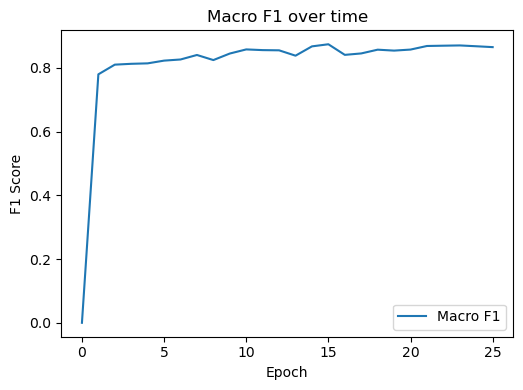

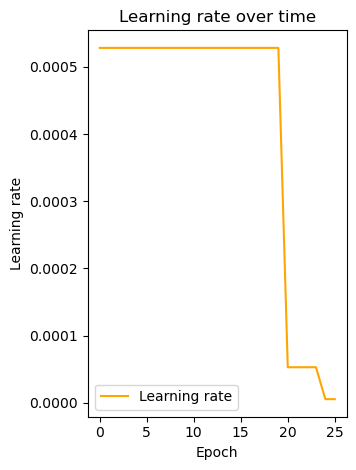

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(f1, label='Macro F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Macro F1 over time')
plt.legend()
plt.savefig('f1.png')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning rate', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate over time')
plt.legend()
plt.savefig('lr.png')
plt.tight_layout()
plt.show()

In [ ]:
MODEL_PATH = 'Model\\model_full.pth'

model = torch.load(MODEL_PATH)

# Instead of using the basic [0.5, 0.5, 0.5] thresholds, we can select the thresholds per label
# based on which threshold the model performs best with
def tune_optimal_thresholds(model):
    optimal_thresholds = []
    for i in range(len(label_map)):
        best_f1 = 0
        best_threshold = 0.5
        # For every class we brute force test a bunch of thresholds to see which one leads to the best performance
        # and save that one
        for threshold in np.linspace(0, 1.0, 101):
            current_thresholds = [0.5] * len(label_map)
            current_thresholds[i] = threshold
            result = evaluate(model, test_loader, device=device, thresholds=current_thresholds)
            f1 = result['macro']['f1_score']
            
            
            if (f1 > best_f1):
                best_f1 = f1
                best_threshold = threshold
        optimal_thresholds.append(best_threshold)
    return optimal_thresholds

# Since our labels are imbalanced we might see some improvement gain from optimal threshold tuning
thresholds = tune_optimal_thresholds(model)
print(thresholds)
#[0.6900000000000001, 0.09, 0.23]

In [28]:
validation_set = IRDataset('spectra_validation.csv')
validation_loader = DataLoader(validation_set, batch_size=64)

results = evaluate(model, validation_loader, device=device, thresholds=thresholds)
control = evaluate(model, validation_loader, device=device, thresholds=[0.5, 0.5, 0.5])

print(results)
print(control)

# While optimal threshold tuning improved performance on the test set, the same can't be said for the validation set.
# This is most likely because the optimal thresholds are overfitted on the test set and don't generalize very well, which
# could be due to the test set's small size.

{'phenol': {'precision': 0.8709677419354839, 'recall': 0.7605633802816901, 'f1_score': 0.8120300751879699}, 'aldehyde': {'precision': 0.8333333333333334, 'recall': 0.7954545454545454, 'f1_score': 0.8139534883720929}, 'arene': {'precision': 0.9101239669421488, 'recall': 0.9734806629834254, 'f1_score': 0.9407367859049653}, 'macro': {'f1_score': 0.855573449821676, 'EMR': 0.9078104993597952}}
{'phenol': {'precision': 0.8571428571428571, 'recall': 0.7605633802816901, 'f1_score': 0.8059701492537313}, 'aldehyde': {'precision': 0.8974358974358975, 'recall': 0.7954545454545454, 'f1_score': 0.8433734939759037}, 'arene': {'precision': 0.9194061505832449, 'recall': 0.958011049723757, 'f1_score': 0.9383116883116882}, 'macro': {'f1_score': 0.8625517771804411, 'EMR': 0.9078104993597952}}
